# Libraries

In [1]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import re
import string

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Embedding, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Data Information

In [2]:
train_file_id = '1SsvmjOOn2rIWDUPfQ6xJGFwWbVoxTd-2'
train_output_file = '/content/train.csv'
train_download_url = f'https://drive.google.com/uc?id={train_file_id}'
gdown.download(train_download_url, train_output_file, quiet=False)
df = pd.read_csv(train_output_file, sep = '\t')

Downloading...
From: https://drive.google.com/uc?id=1SsvmjOOn2rIWDUPfQ6xJGFwWbVoxTd-2
To: /content/train.csv
100%|██████████| 515k/515k [00:00<00:00, 46.0MB/s]


In [3]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
obj = [col for col in df.columns if df[col].nunique() <= 10]
for col in obj:
  print(f"====={col}=====")
  unique_values = df[col].unique()
  n_unique_values = df[col].nunique()
  value_counts = df[col].value_counts()

  print(f"Unique values in {col}: {unique_values}")
  print(f"Number of unique values in {col}: {n_unique_values}\n")
  print(f"Value counts in {col}:\n{value_counts}\n")

=====rating=====
Unique values in rating: [5 4 3 2 1]
Number of unique values in rating: 5

Value counts in rating:
rating
5    2286
4     455
1     161
3     152
2      96
Name: count, dtype: int64

=====feedback=====
Unique values in feedback: [1 0]
Number of unique values in feedback: 2

Value counts in feedback:
feedback
1    2893
0     257
Name: count, dtype: int64



# Data Cleaning

In [6]:
df = df.dropna()

In [7]:
df.duplicated().sum()

715

# EDA Before Data Preprocessing

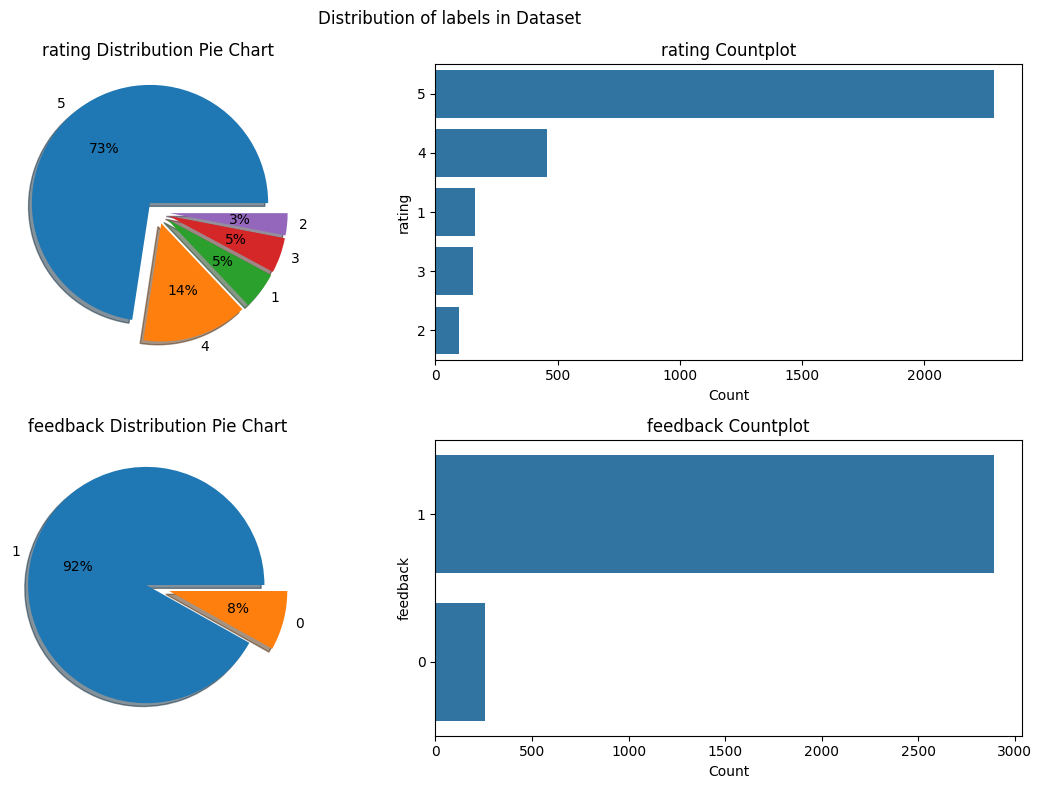

In [8]:
fig, axes = plt.subplots(len(obj), 2, figsize = (12, 8))

for i, col in enumerate(obj):
  ax = axes[i, 0]
  ax.pie(
      df[col].value_counts(),
      shadow = True,
      explode = [0.1 for _ in range(df[col].nunique())],
      autopct='%1.f%%',
      labels = df[col].value_counts().index
  )

  ax.set_aspect('equal')
  ax.set_title(f'{col} Distribution Pie Chart')

  ax1 = axes[i, 1]
  sns.countplot(y = col, ax = ax1, order = df[col].value_counts().index, data = df)
  ax1.set_xlabel('Count')
  ax1.set_ylabel(col)
  ax1.set_title(f'{col} Countplot')

fig.suptitle('Distribution of labels in Dataset')
plt.tight_layout()
plt.show()

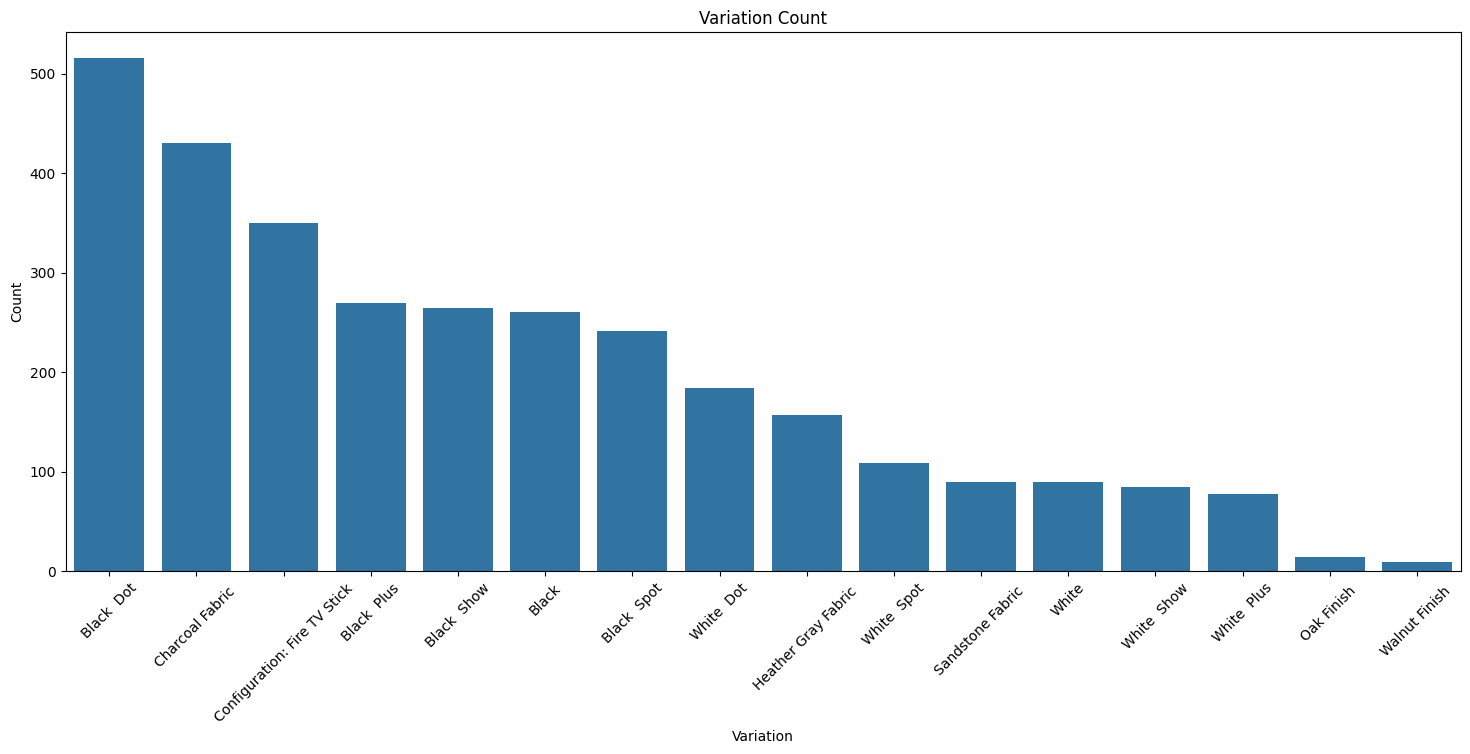

In [9]:
order = df['variation'].value_counts().index

plt.figure(figsize = (18,7))
sns.countplot(x='variation', data = df, order = order)
plt.xlabel('Variation')
plt.ylabel('Count')
plt.title('Variation Count')

plt.xticks(rotation=45)
plt.show()

# EDA After Time Feature Engineering

In [10]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')
# df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.day_name()

In [11]:
df.head()

,rating,date,variation,verified_reviews,feedback,month,day,weekday
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,7,31,Tuesday
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,7,31,Tuesday
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,31,Tuesday
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,31,Tuesday
4,5,2018-07-31,Charcoal Fabric,Music,1,7,31,Tuesday


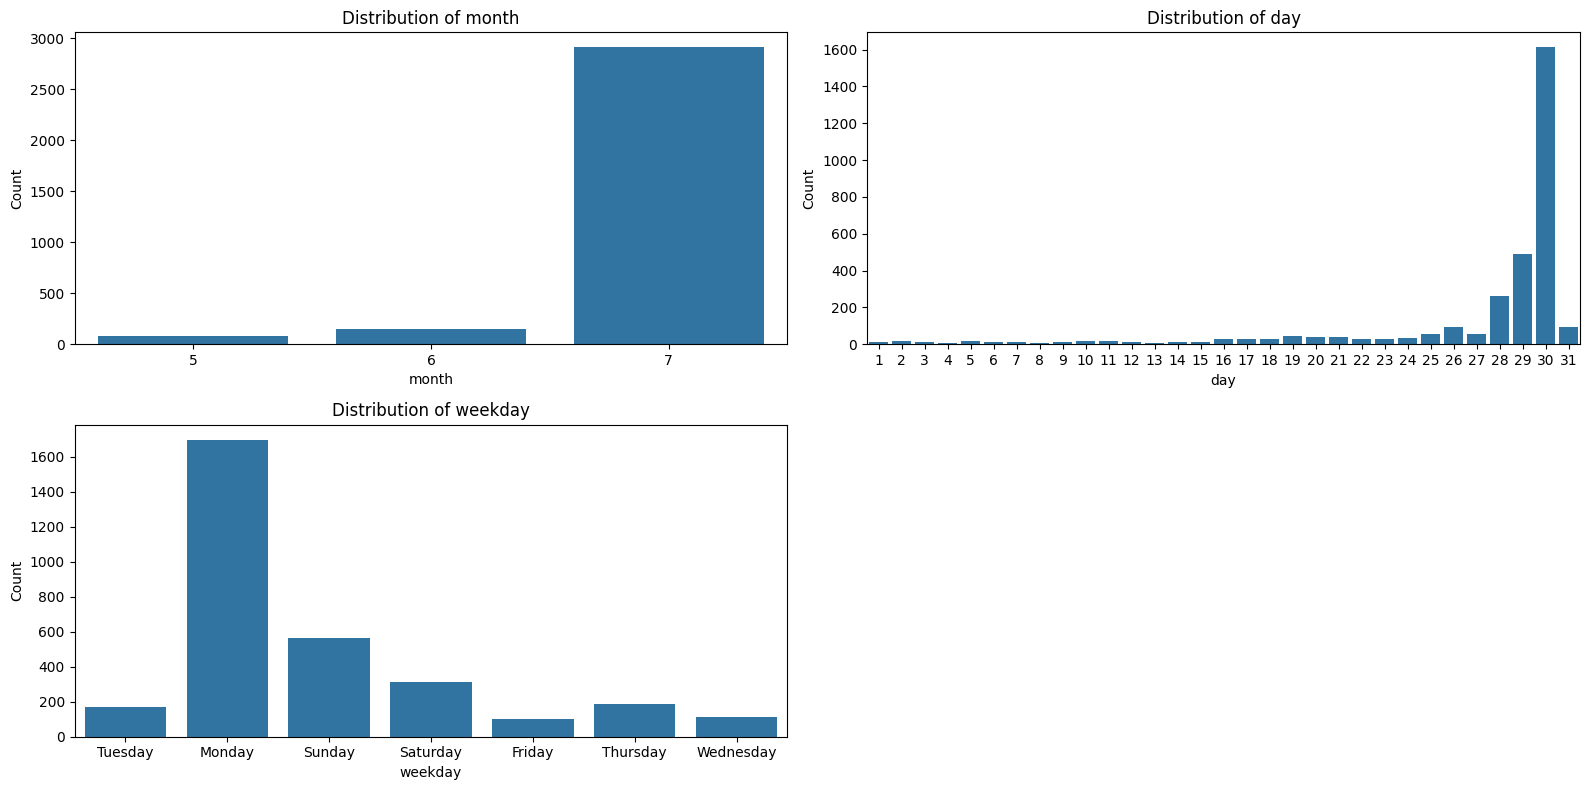

In [12]:
time_cols = ['month', 'day', 'weekday']
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(time_cols):
  ax = sns.countplot(x=col, data=df, ax=axes[i])
  ax.set_xlabel(col)
  ax.set_ylabel('Count')
  ax.set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Lenght Counts

### By feedback

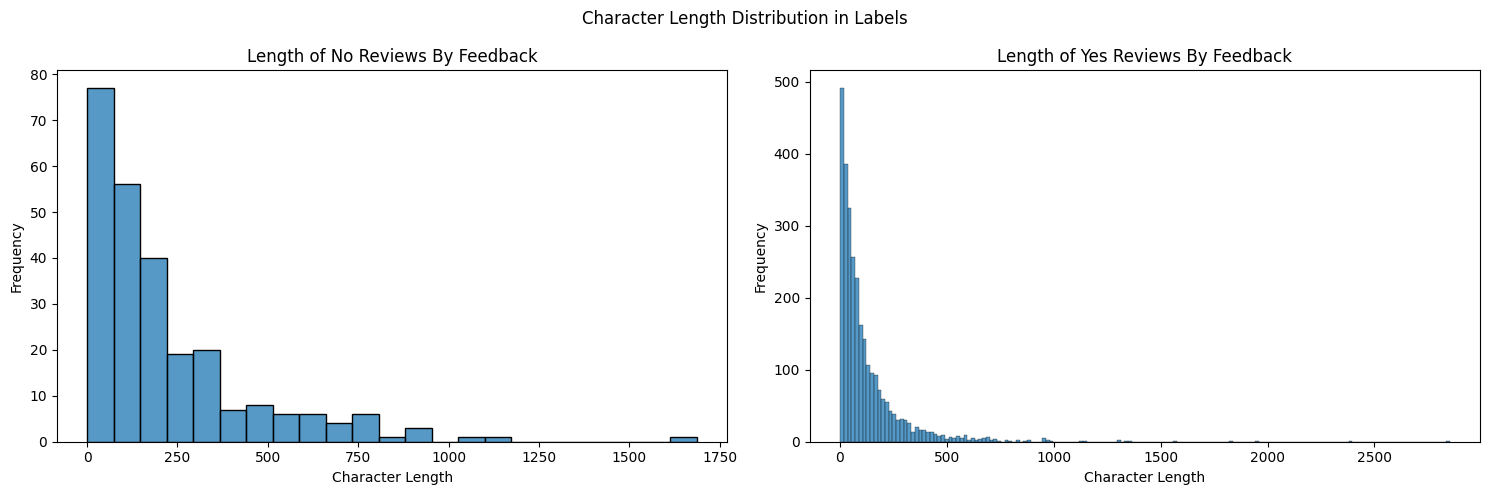

In [13]:
labels = [0, 1]
label_names = ["No", "Yes"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

for i, label in enumerate(labels):
  length_text = df[df['feedback'] == label]['verified_reviews'].str.len()
  ax = sns.histplot(length_text, ax=axes[i])
  ax.set_title(f'Length of {label_names[label]} Reviews By Feedback')
  ax.set_xlabel('Character Length')
  ax.set_ylabel('Frequency')

fig.suptitle('Character Length Distribution in Labels')
plt.tight_layout()
plt.show()

### By rating

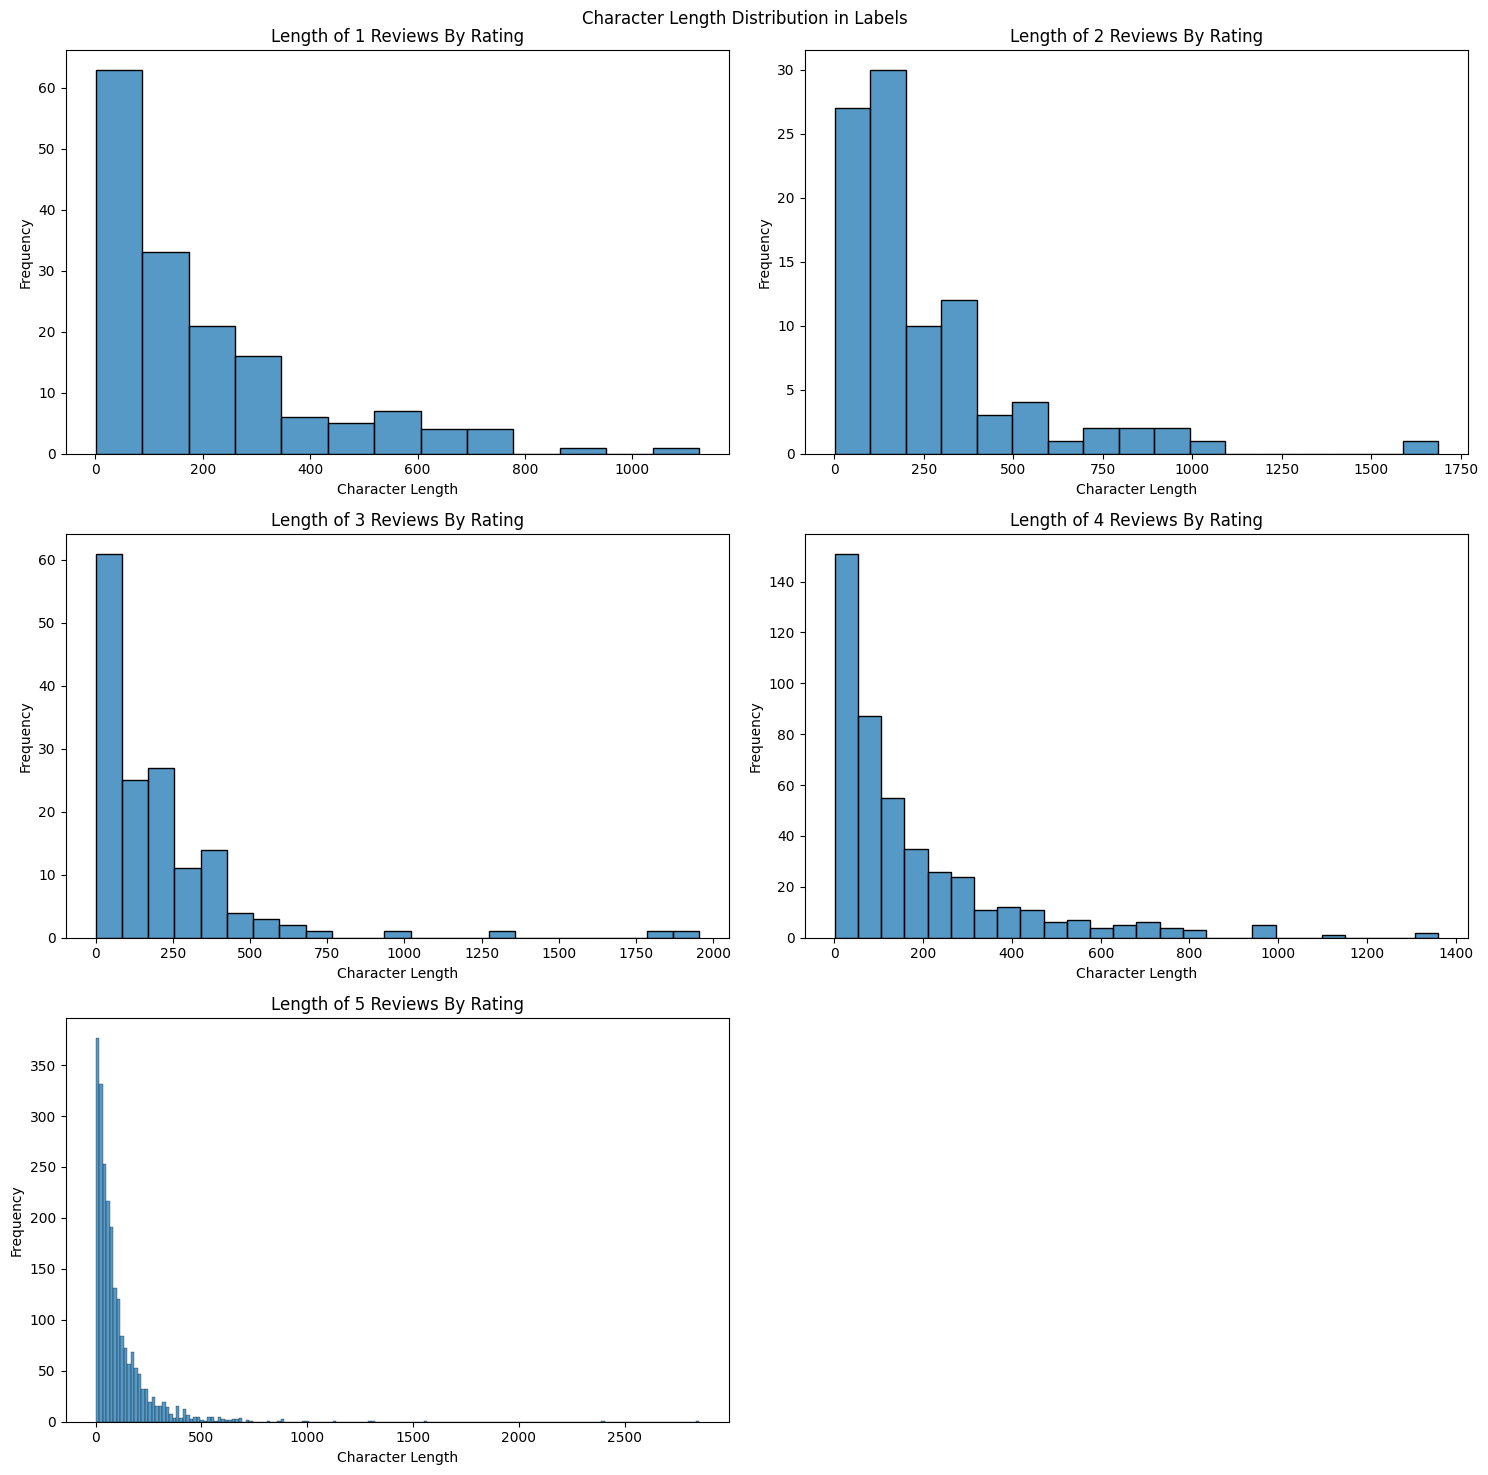

In [14]:
labels = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, label in enumerate(labels):
  length_text = df[df['rating'] == label]['verified_reviews'].str.len()
  ax = sns.histplot(length_text, ax=axes[i])
  ax.set_title(f'Length of {label} Reviews By Rating')
  ax.set_xlabel('Character Length')
  ax.set_ylabel('Frequency')

for j in range(i+1, len(axes)):
  fig.delaxes(axes[j])

fig.suptitle('Character Length Distribution in Labels')
plt.tight_layout()
plt.show()

## Word Count

### By feedback

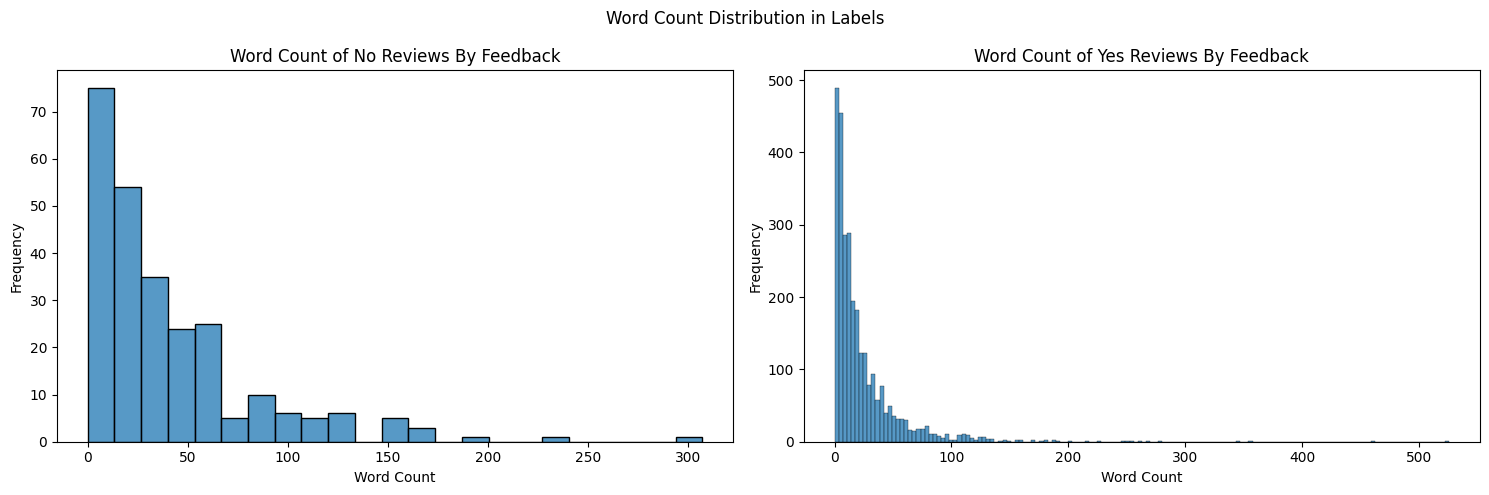

In [15]:
labels = [0, 1]
label_names = ["No", "Yes"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

for i, label in enumerate(labels):
  word_count = df[df['feedback'] == label]['verified_reviews'].apply(lambda x: len(str(x).split()))
  ax = sns.histplot(word_count, ax=axes[i], kde=False)
  ax.set_title(f'Word Count of {label_names[label]} Reviews By Feedback')
  ax.set_xlabel('Word Count')
  ax.set_ylabel('Frequency')

for j in range(len(labels), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Word Count Distribution in Labels')
plt.tight_layout()
plt.show()

### Rating

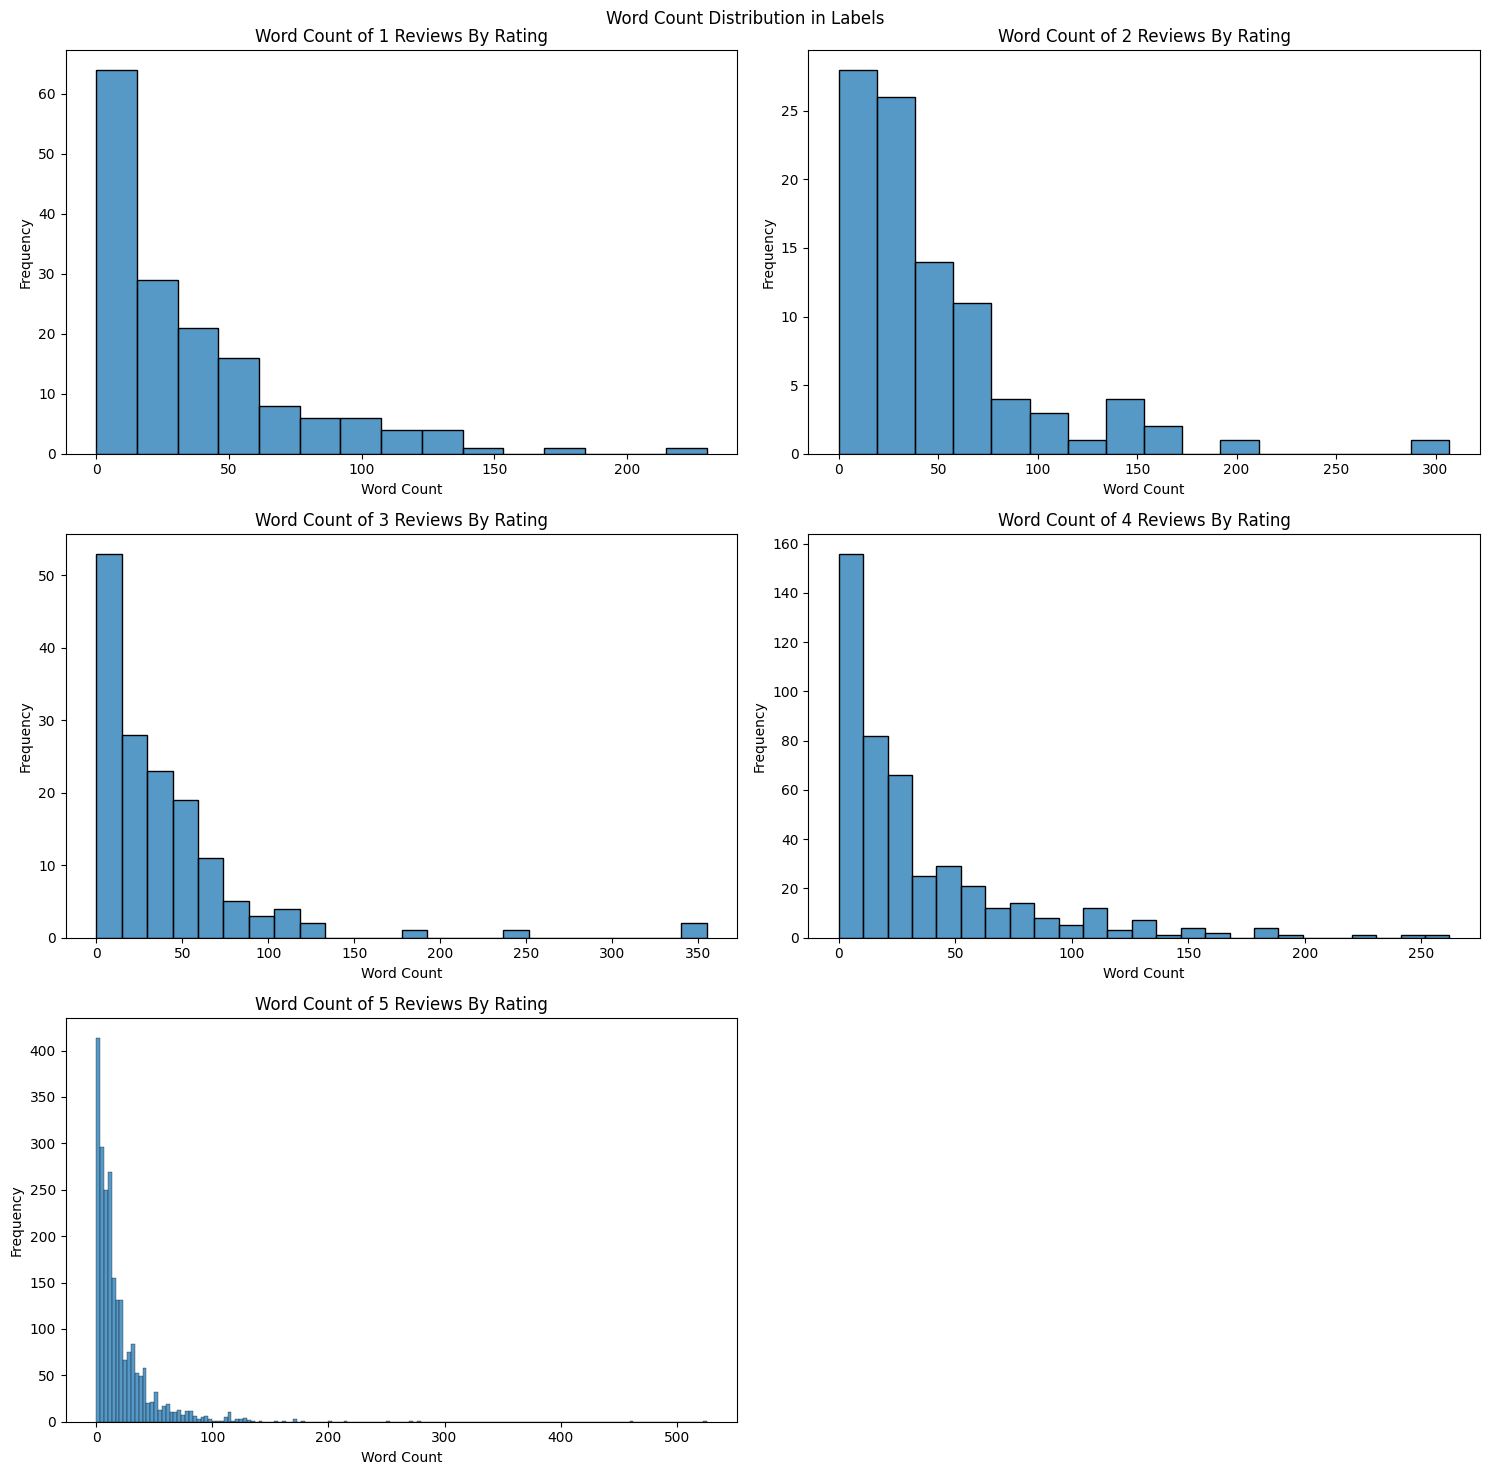

In [16]:
labels = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, label in enumerate(labels):
  word_count = df[df['rating'] == label]['verified_reviews'].apply(lambda x: len(str(x).split()))
  ax = sns.histplot(word_count, ax=axes[i], kde=False)
  ax.set_title(f'Word Count of {label} Reviews By Rating')
  ax.set_xlabel('Word Count')
  ax.set_ylabel('Frequency')

for j in range(len(labels), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Word Count Distribution in Labels')
plt.tight_layout()
plt.show()

# Data Preprocessing

## Text Cleaning

In [17]:
punc = string.punctuation

def text_cleaning(text):
  # Step 1: Transform to lowercase
  text = text.lower()

  # Step 2: Remove HTML tags
  text = re.sub(r'<.*?>', '', text)

  # Step 3: Remove numbers
  text = re.sub(r'\d+', '', text)

  # Step 4: Remove punctuation
  text = "".join([i for i in text if i not in punc])

  # Step 5: Remove emoticons and emojis
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'[^\x00-\x7F]+', '', text)

  return text

df['clean_verified_reviews'] = df['verified_reviews'].apply(text_cleaning)
df.head()

,rating,date,variation,verified_reviews,feedback,month,day,weekday,clean_verified_reviews
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,7,31,Tuesday,love my echo
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,7,31,Tuesday,loved it
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,31,Tuesday,sometimes while playing a game you can answer ...
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,31,Tuesday,i have had a lot of fun with this thing my yr...
4,5,2018-07-31,Charcoal Fabric,Music,1,7,31,Tuesday,music


## Tokenize

In [18]:
nltk.download('punkt')

def tokenize(text):
  token = word_tokenize(text)
  return token

df['clean_verified_reviews'] = df['clean_verified_reviews'].apply(tokenize)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,rating,date,variation,verified_reviews,feedback,month,day,weekday,clean_verified_reviews
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,7,31,Tuesday,"[love, my, echo]"
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,7,31,Tuesday,"[loved, it]"
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,31,Tuesday,"[sometimes, while, playing, a, game, you, can,..."
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,31,Tuesday,"[i, have, had, a, lot, of, fun, with, this, th..."
4,5,2018-07-31,Charcoal Fabric,Music,1,7,31,Tuesday,[music]


## Stopwords

In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def stopword(words):
  words = [word for word in words if len(word) > 2 and word not in stop_words]
  return words

df['clean_verified_reviews'] = df['clean_verified_reviews'].apply(stopword)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,rating,date,variation,verified_reviews,feedback,month,day,weekday,clean_verified_reviews
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,7,31,Tuesday,"[love, echo]"
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,7,31,Tuesday,[loved]
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,31,Tuesday,"[sometimes, playing, game, answer, question, c..."
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,31,Tuesday,"[lot, fun, thing, old, learns, dinosaurs, cont..."
4,5,2018-07-31,Charcoal Fabric,Music,1,7,31,Tuesday,[music]


## Lemmatizer

In [20]:
nltk.download('wordnet')
lm = WordNetLemmatizer()

def lemmatizer(words):
  return [lm.lemmatize(word, pos = 'v') for word in words if len(word) > 2]

df['clean_verified_reviews'] = df['clean_verified_reviews'].apply(lemmatizer)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,rating,date,variation,verified_reviews,feedback,month,day,weekday,clean_verified_reviews
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,7,31,Tuesday,"[love, echo]"
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,7,31,Tuesday,[love]
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,31,Tuesday,"[sometimes, play, game, answer, question, corr..."
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,31,Tuesday,"[lot, fun, thing, old, learn, dinosaurs, contr..."
4,5,2018-07-31,Charcoal Fabric,Music,1,7,31,Tuesday,[music]


In [21]:
df['clean_verified_reviews'] = df['clean_verified_reviews'].apply(lambda x: " ".join(x))

all_reviews = ' '.join(df['clean_verified_reviews'].dropna())
words = all_reviews.split()
freq_comm = pd.Series(words).value_counts()
freq_comm

,count
love,1057
echo,856
great,717
use,675
work,644
...,...
goodsome,1
scream,1
newno,1
showno,1


## Remove rare words

In [22]:
rare_words = freq_comm[freq_comm == 1].index
df['clean_verified_reviews'] = df['clean_verified_reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in rare_words]))

text = ' '.join(df['clean_verified_reviews'].dropna())
text_length = len(text)
print(f'Length of the combined text: {text_length}')

Length of the combined text: 234626


# WordCloud

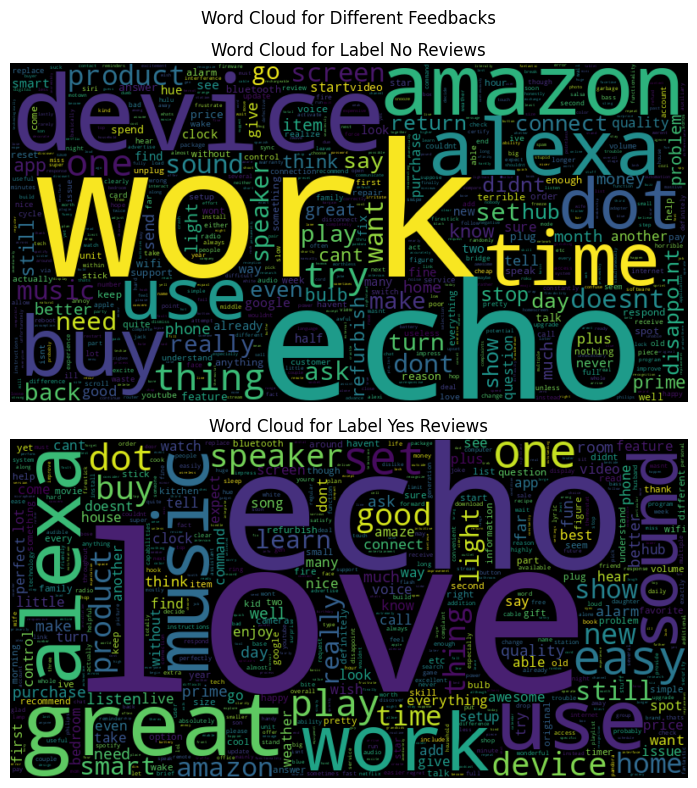

In [23]:
labels = [0, 1]
label_names = ['No', 'Yes']

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes = axes.flatten()

for i, lab in enumerate(labels):
  rev = ' '.join(df[df['feedback'] == lab]['clean_verified_reviews'].dropna())

  ax = axes[i]
  wordcloud = WordCloud(max_words=2000, width=800, height=400, collocations=False).generate(rev)

  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis('off')
  ax.set_title(f"Word Cloud for Label {label_names[i]} Reviews")

fig.suptitle('Word Cloud for Different Feedbacks')
plt.tight_layout()
plt.show()

# Modelling

## Train Test Split

In [24]:
print("Total +ve reviews: ", df[df['feedback'] == 1]['clean_verified_reviews'].count())
print("Total -ve reviews: ", df[df['feedback'] == 0]['clean_verified_reviews'].count())

pos_train = df[df['feedback'] == 1][['clean_verified_reviews', 'feedback']].head(2025)
neg_train = df[df['feedback'] == 0][['clean_verified_reviews', 'feedback']].head(180)

pos_test = df[df['feedback'] == 1][['clean_verified_reviews', 'feedback']].tail(868)
neg_test = df[df['feedback'] == 0][['clean_verified_reviews', 'feedback']].tail(77)

Total +ve reviews:  2893
Total -ve reviews:  256


In [25]:
df_train = pd.concat([pos_train, neg_train]).sample(frac=1).reset_index(drop=True)
df_test = pd.concat([pos_test, neg_test]).sample(frac=1).reset_index(drop=True)

print("Train dataset head:")
print(df_train.head())
print("\nTest dataset head:")
print(df_test.head())

Train dataset head:
                              clean_verified_reviews  feedback
0  first step smart home soon add one item grocer...         1
1  describe receive time like automatic enrolment...         1
2            alexa throughout housethe future arrive         1
3         work great buy gift boyfriend easy fun use         1
4  like weather options alexa search need improve...         1

Test dataset head:
                              clean_verified_reviews  feedback
0        buy sister hasnt complaints yet think great         1
1                                       prime day do         1
2                    great product understand accent         1
3                          really love apps one spot         1
4  old amazon fire stick keep crash use sling buy...         0


In [26]:
X_train = df_train['clean_verified_reviews']
X_test = df_test['clean_verified_reviews']
y_train = df_train['feedback']
y_test = df_test['feedback']

## Deep Learning ANN

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_dl = tokenizer.texts_to_matrix(X_train, mode='count')
X_test_dl = tokenizer.texts_to_matrix(X_test, mode='count')

n_words = X_test_dl.shape[1]
print("n_words", n_words)

n_words 1799


In [28]:
model = Sequential([
    Input(shape=(n_words,)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['acc'])

#print(model.summary())

In [30]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(X_train_dl, y_train, epochs=20, validation_data=(X_test_dl, y_test,),
                    verbose=1, callbacks=callbacks)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - acc: 0.5251 - loss: 1.0684 - val_acc: 0.4815 - val_loss: 0.7023
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.5599 - loss: 0.8991 - val_acc: 0.6783 - val_loss: 0.6786
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5539 - loss: 0.8498 - val_acc: 0.7725 - val_loss: 0.6484
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.6666 - loss: 0.7001 - val_acc: 0.8159 - val_loss: 0.6147
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6695 - loss: 0.6938 - val_acc: 0.8392 - val_loss: 0.5785
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.6781 - loss: 0.6410 - val_acc: 0.8529 - val_loss: 0.5450
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.7313 - loss: 0.5963 - val_acc: 0.8656 - val_loss: 0.5010
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.7340 - loss: 0.5648 - val_acc: 0.8751 - val_loss: 0.4649
Epoch 9/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.7549

In [31]:
def prediction(X_test, model):
    y_pred = model.predict(X_test)
    return y_pred

predictions_keras = prediction(X_test_dl, model)

pred_ann = [1 if y >= 0.5 else 0 for y in predictions_keras.flatten()]

accuracy = accuracy_score(y_test, pred_ann)
print("Accuracy score with Keras:", accuracy)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy score with Keras: 0.9174603174603174


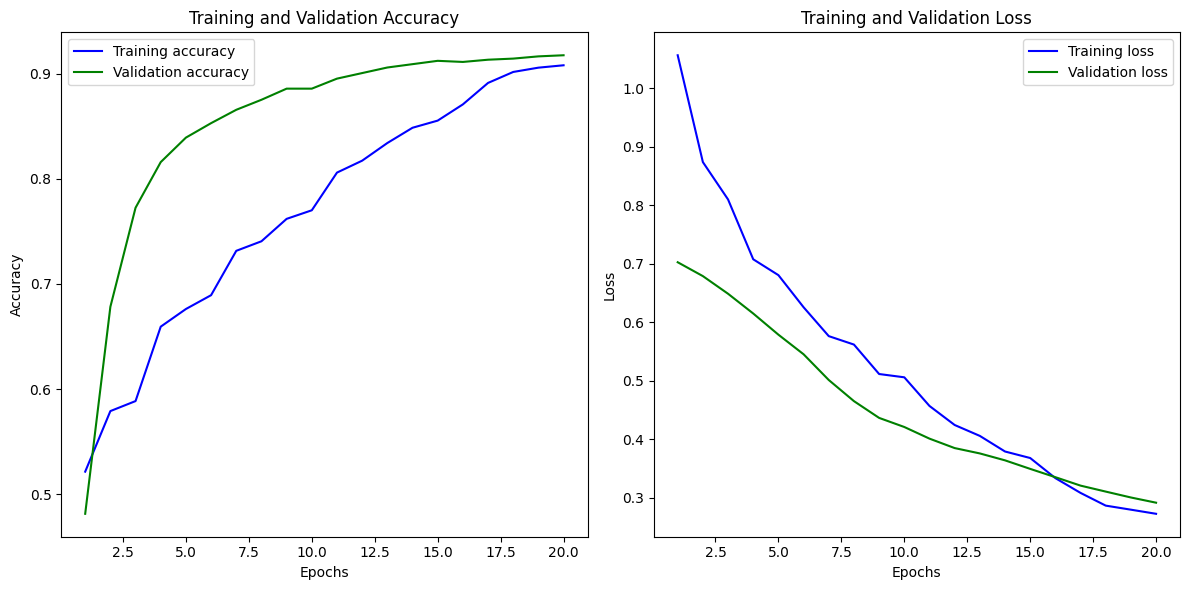

In [32]:
def plot_history(history):
  accuracy = history.history['acc']
  val_accuracy = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, accuracy, 'b', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_history(history)

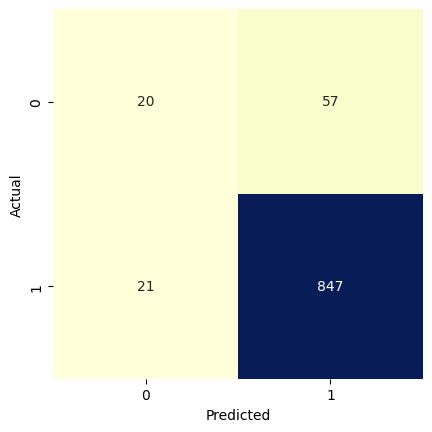

In [33]:
cm_ann = confusion_matrix(y_test, pred_ann)
names = np.unique(pred_ann)
sns.heatmap(cm_ann, square=True, annot=True, cbar=False, xticklabels=names, yticklabels=names, cmap='YlGnBu', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Deep Learning CNN

In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [35]:
encoded_docs = tokenizer.texts_to_sequences(X_train)
max_length = max([len(s.split()) for s in X_train])
X_train_dl1 = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

encoded_docs = tokenizer.texts_to_sequences(X_test)
X_test_dl1 = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

vocab_size = len(tokenizer.word_index) + 1
print("vocab_size =", vocab_size)

vocab_size = 1799


In [36]:
model1 = Sequential([
    Embedding(vocab_size, 100),
    Conv1D(filters=32, kernel_size=8, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [37]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history1 = model1.fit(X_train_dl1, y_train, epochs=10, verbose=1)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - acc: 0.9215 - loss: 0.3429
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - acc: 0.9175 - loss: 0.2685
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - acc: 0.9141 - loss: 0.1741
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - acc: 0.9528 - loss: 0.1073
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - acc: 0.9798 - loss: 0.0825
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - acc: 0.9806 - loss: 0.0787
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - acc: 0.9897 - loss: 0.0652
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - acc: 0.9884 - loss: 0.0671
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - acc: 0.9888 - loss: 0.0738
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - acc: 0.9878 - loss: 0.0680


In [38]:
predictions_cnn = prediction(X_test_dl1, model1)
pred_cnn = [1 if y >= 0.5 else 0 for y in predictions_cnn.flatten()]

accuracy_cnn = accuracy_score(y_test, pred_cnn)
print("Accuracy score with CNN:", accuracy_cnn)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Accuracy score with CNN: 0.9248677248677248


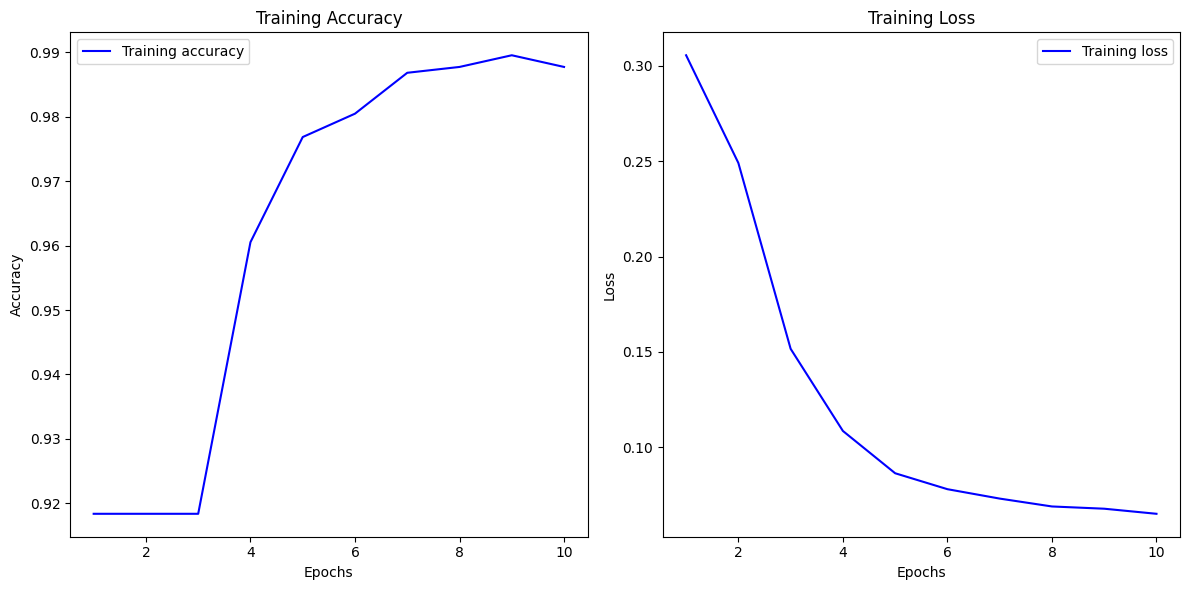

In [39]:
def plot_history(history):
  accuracy = history.history['acc']
  loss = history.history['loss']

  epochs = range(1, len(accuracy) + 1)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, accuracy, 'b', label='Training accuracy')
  plt.title('Training Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.title('Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_history(history1)

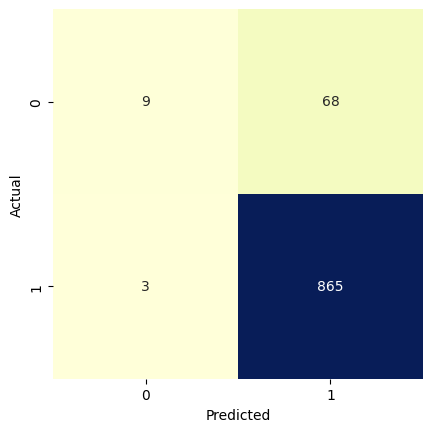

In [40]:
cm_cnn = confusion_matrix(y_test, pred_cnn)
names = np.unique(pred_cnn)
sns.heatmap(cm_cnn, square=True, annot=True, cbar=False, xticklabels=names, yticklabels=names, cmap='YlGnBu', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()